In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.insert(0, 'models')
sys.path.insert(0, 'utils')
sys.path.insert(1, '../dsvae/yukun_disentanglement_lib/')
import tensorflow_hub as hub
import tensorflow as tf
import yukun_disentanglement_lib
import celeba
import numpy as np
import wandb
import matplotlib.pyplot as plt
import numpy as np
import torch
import argparse
from plotting_utils import plot_pytorch_images
from misc import merge

from dsvae_model import DSVAE, loss_function
from datasets import DSVAE_DATA, VAE_DATA

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument("--num_datapoints", help="num datapoints", default=10000, type=int)
parser.add_argument("--z_dim", help="z dimension", default=85, type=int)
parser.add_argument("--device", help="gpu id", default=0, type=int)
parser.add_argument("--nb_epochs", help="number of epochs", default=500, type=int)
parser.add_argument("--start_epoch", help="epoch to start training from (requires checkpoints)", default=0, type=int)
parser.add_argument("--save_interval", help="epochs to save model", default=10, type=int)
parser.add_argument("--run_seed", help="run seed of TCVAE", default=100, type=int)
parser.add_argument("--lr", help="learning rate", default=.0001, type=float)
parser.add_argument("--batch_size", help="batch size", default=100, type=int)
parser.add_argument("--has_validation", help="If True, will use validation set", default=True, type=bool)
parser.add_argument("--validation_size", help="Validation set size", default=2000, type=int)

args = parser.parse_args([])

num_datapoints=args.num_datapoints

log = True
if log:
    wandb.init(project="dsvae_vae", name="celeba_{}_128".format(num_datapoints))
    wandb.config.update(args)

device = args.device
print("z_dim: {}".format(args.z_dim))
print("GPU: {}".format(device))
print("start_epoch: {}".format(args.start_epoch))
print("save_interval: {}".format(args.save_interval))
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[args.device], 'GPU')

wandb: Wandb version 0.8.30 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


z_dim: 85
GPU: 0
start_epoch: 0
save_interval: 10


In [3]:
save = True
load = True
validation_size = 0
if args.has_validation:
    validation_size = args.validation_size
num_samples = num_datapoints + validation_size
num_y_samples = 10
# vae = vae.cpu()
# vae.device = None
if not load:
    vae_path = 'UPVAE_10K_128'
    vae = torch.load(vae_path)
    vae.eval()
    vae.to(device)
    dta = celeba.CelebA(celeba_path="../dsvae/yukun_disentanglement_lib/img_align_celeba", 
                        num_samples=num_samples, 
                        res=128
                       )
    inputs = np.float32(dta.images)
    torch_inputs = torch.from_numpy(inputs).permute(0,3,1,2)
    torch_dataset = VAE_DATA(torch_inputs)
    torch_data_loader = torch.utils.data.DataLoader(torch_dataset, batch_size=args.batch_size, shuffle=False)
    ys = np.float32(np.empty((num_samples, num_y_samples, 3, 128, 128)))
    for (i, X) in enumerate(torch_data_loader):
        x = X.to(device)
        _, z_mu, z_var = vae(x)
        for j in range(num_y_samples):
            z_sample = torch.distributions.Normal(z_mu, z_var).sample()
            with torch.no_grad():
                x_hat = vae.decode(z_sample)
            ys[i*100:(i+1)*100,j] = x_hat.detach().cpu().numpy()
            
    train_inputs = np.float32(dta.images[:num_datapoints])
    train_ys = np.float32(ys[:num_datapoints])
    val_inputs = np.float32(dta.images[num_datapoints:])
    val_ys = np.float32(ys[num_datapoints:])
    
    del dta
    del vae
    if save:
        np.save('saved_data/train_inputs_{}_dsvae'.format(num_samples), train_inputs)
        np.save('saved_data/train_ys_{}_dsvae'.format(num_samples), train_ys)
        if args.has_validation:
            np.save('saved_data/val_inputs_{}_dsvae'.format(num_samples), val_inputs)
            np.save('saved_data/val_ys_{}_dsvae'.format(num_samples), val_ys)
else:  
    train_inputs = np.load('saved_data/train_inputs_{}_dsvae.npy'.format(num_samples))
    train_ys = np.load('saved_data/train_ys_{}_dsvae.npy'.format(num_samples))
    if args.has_validation:
        val_inputs = np.load('saved_data/val_inputs_{}_dsvae.npy'.format(num_samples))
        val_ys = np.load('saved_data/val_ys_{}_dsvae.npy'.format(num_samples))
    
torch_train_inputs = torch.from_numpy(train_inputs).permute(0,3,1,2)
torch_train_ys = torch.from_numpy(train_ys)
torch_train_dataset = DSVAE_DATA(torch_train_inputs, torch_train_ys)
torch_train_data_loader = torch.utils.data.DataLoader(torch_train_dataset, 
                                                      batch_size=args.batch_size, 
                                                      shuffle=True
                                                     )

if args.has_validation:
    torch_val_inputs = torch.from_numpy(val_inputs).permute(0,3,1,2)
    torch_val_ys = torch.from_numpy(val_ys)
    torch_val_dataset = DSVAE_DATA(torch_val_inputs, torch_val_ys)
    torch_val_data_loader = torch.utils.data.DataLoader(torch_val_dataset, 
                                                        batch_size=args.batch_size, 
                                                        shuffle=False
                                                       )
print("data ready for training")

data ready for training


In [4]:
# plot_pytorch_images(torch_val_dataset[1:6][0], 5);
# plot_pytorch_images(torch_val_dataset[1:6][1][:,5], 5);
# plot_pytorch_images(torch_val_dataset[1:6][1][:,3], 5);

# Instantiating and Training DSVAE

In [5]:
if device != -1 and device is not None:
    dsvae = DSVAE(z_dim=85, y_shape=[3,128,128], input_shape=[3,128,128], device=args.device)
    dsvae.to(device)
else:
    dsvae = DSVAE(z_dim=85, y_shape=[3,128,128], input_shape=[3,128,128], device=None)
optimizer = torch.optim.Adam(params=dsvae.parameters(), lr=args.lr)

Training for 1500 epochs...


wandb: Wandb version 0.8.30 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


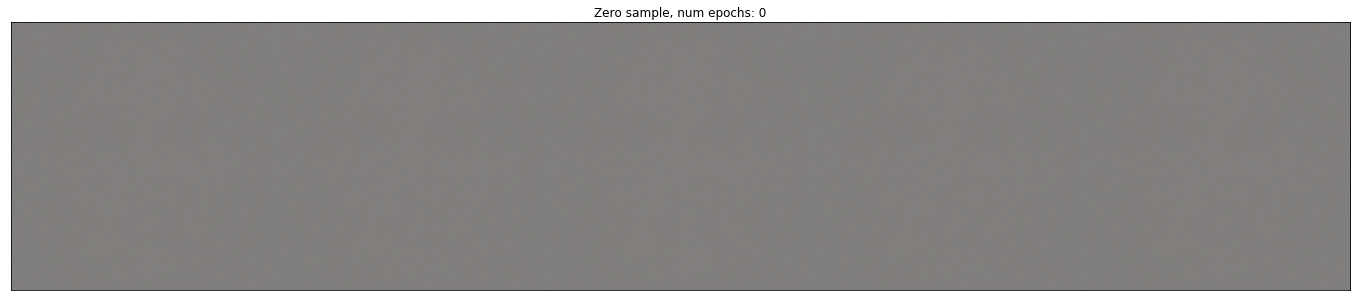

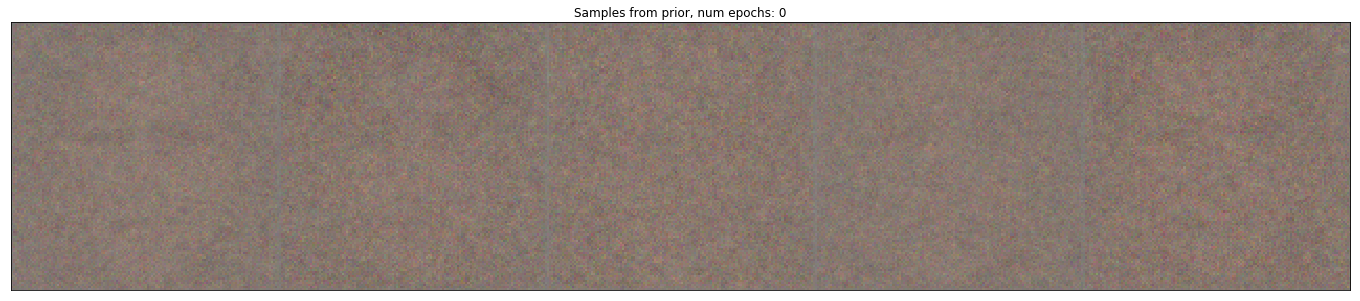

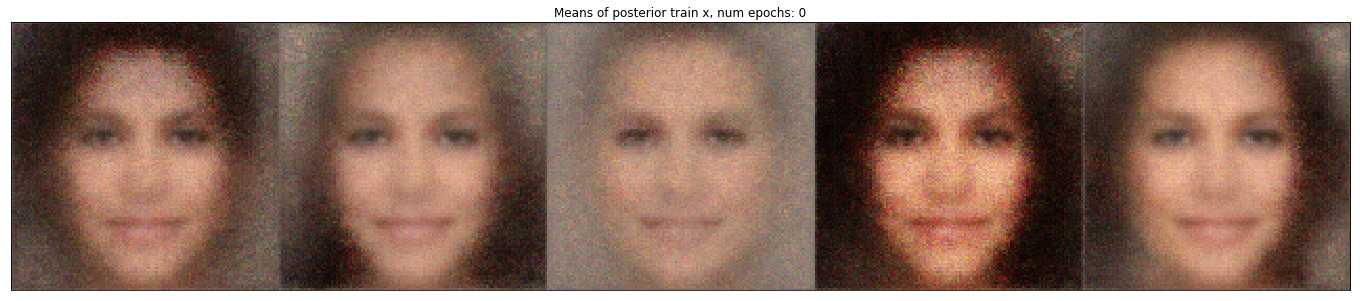

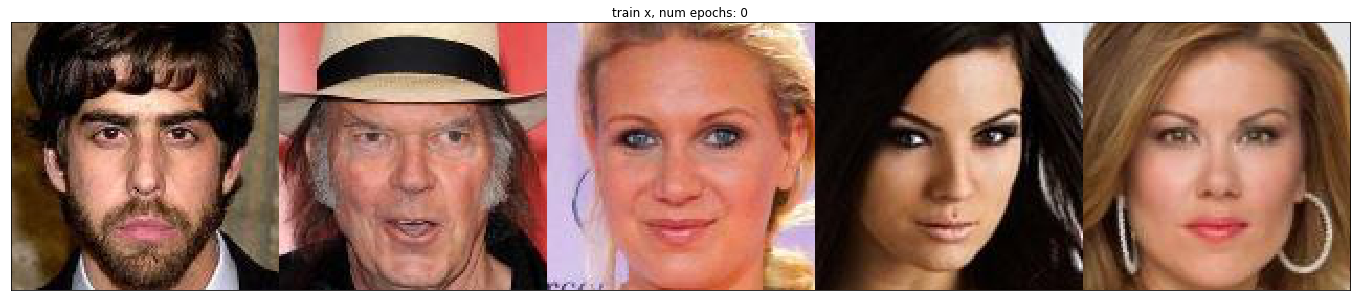

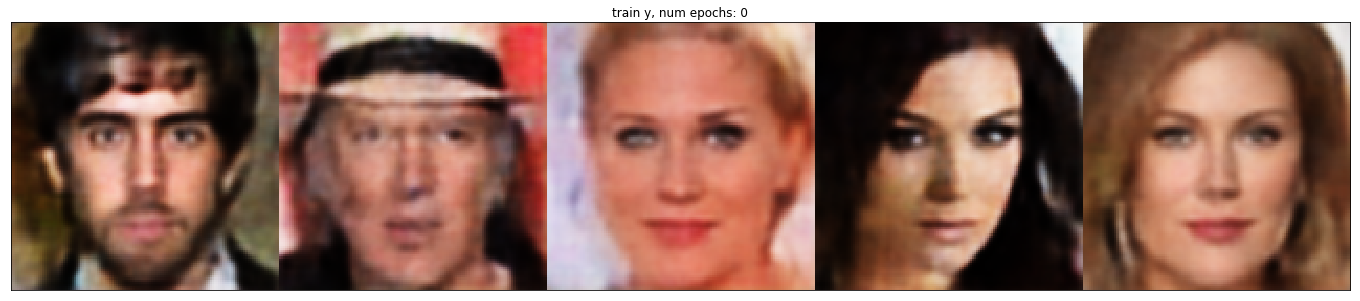

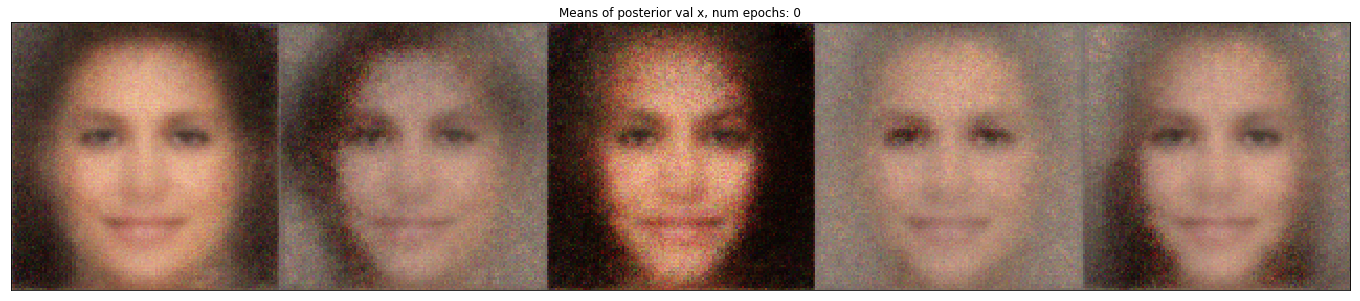

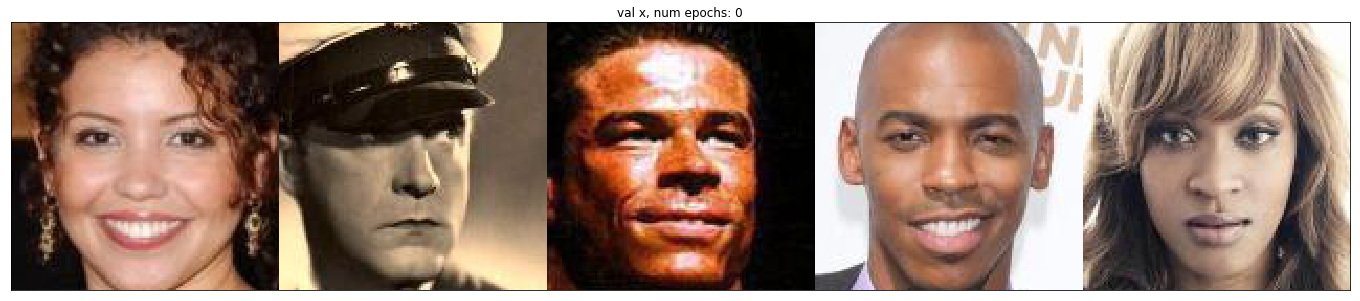

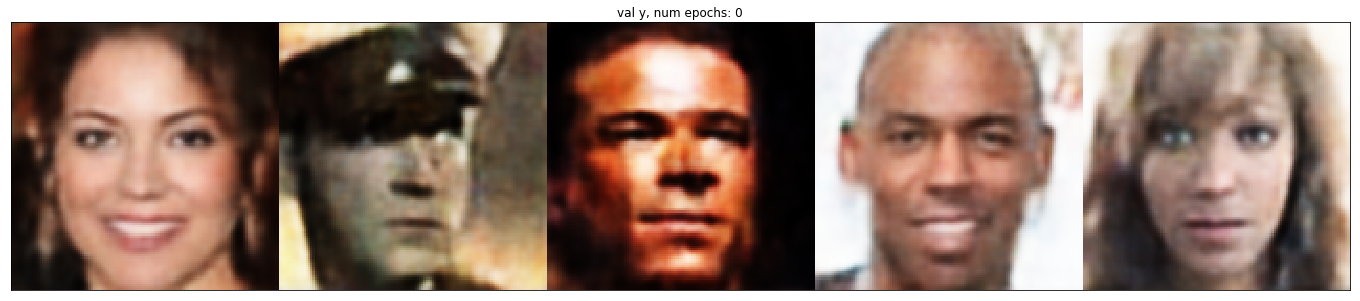

RuntimeError: CUDA out of memory. Tried to allocate 1024.00 MiB (GPU 0; 15.90 GiB total capacity; 12.13 GiB already allocated; 216.19 MiB free; 14.93 GiB reserved in total by PyTorch)

In [6]:
dsvae.train()
normal = torch.distributions.Normal(0,1)
print("Training for {} epochs...".format(1500))
for n in range(0, 1500):
    train_loss = 0
    train_recon_loss = 0
    train_kl_loss = 0
    num_examples = 0
    for (i, X) in enumerate(torch_train_data_loader):
        x = X[0]
        y_all = X[1]
        rand_int = np.random.randint(0,num_y_samples)
        y = y_all[:,rand_int]
        if dsvae.cuda:
            x = x.to(device)
            y = y.to(device)
        optimizer.zero_grad()
        x_hat, z_mu, z_var = dsvae(x, y)
        loss, recon_loss, kl_loss = loss_function(x_hat, x, z_mu, z_var)
        train_loss += loss.item()
        train_recon_loss += recon_loss.item()
        train_kl_loss += kl_loss.item()
        num_examples += x_hat.shape[0]
        loss.backward()
        optimizer.step()
    if log:
        wandb.log({'train_loss':train_loss/num_examples})
        wandb.log({'train_recon_loss':train_recon_loss/num_examples})
        wandb.log({'train_kl_loss':train_kl_loss/num_examples})
    
    if args.has_validation:
        dsvae.eval()
        val_loss = 0
        val_recon_loss = 0
        val_kl_loss = 0
        num_examples = 0
        for (i, X) in enumerate(torch_val_data_loader):
            x_val = X[0]
            y_all_val = X[1]
            rand_int = np.random.randint(0,num_y_samples)
            y_val = y_all_val[:,rand_int]
            if dsvae.cuda:
                x_val = x_val.to(device)
                y_val = y_val.to(device)
            x_hat_val, z_mu, z_var = dsvae(x_val, y_val)
            loss, recon_loss, kl_loss = loss_function(x_hat_val, x_val, z_mu, z_var)
            val_loss += loss.item()
            val_recon_loss += recon_loss.item()
            val_kl_loss += kl_loss.item()
            num_examples += x_hat_val.shape[0]
        if log:
            wandb.log({'val_loss':val_loss/num_examples})
            wandb.log({'val_recon_loss':val_recon_loss/num_examples})
            wandb.log({'val_kl_loss':val_kl_loss/num_examples})
        dsvae.train()

    if n%20 ==0:
        dsvae.eval() #evaluate model
        z_noise = normal.sample((x.shape[0],85))
        z_zeros = torch.zeros((x.shape[0],85))
        if dsvae.cuda:
            z_noise = z_noise.to(device)
            z_zeros = z_zeros.to(device)
        x_hat_noise = dsvae.decode(z_noise, y)
        x_hat_zeros = dsvae.decode(z_zeros, y)
        
        fig = plot_pytorch_images(x_hat_zeros[:5], num_images=5, title='Zero sample, num epochs: {}'.format(n))
        if log:
            wandb.log({'Zero sample':fig})
            
        fig = plot_pytorch_images(x_hat_noise[:5], num_images=5, title='Samples from prior, num epochs: {}'.format(n))
        if log:
            wandb.log({'Samples from prior':fig})
            
        fig = plot_pytorch_images(x_hat[:5], num_images=5, title='Means of posterior train x, num epochs: {}'.format(n))
        if log:
            wandb.log({'Means of posterior train x':fig})
            
        fig = plot_pytorch_images(x[:5], num_images=5, title='train x, num epochs: {}'.format(n))
        if log:
            wandb.log({'train x':fig})

        fig = plot_pytorch_images(y[:5], num_images=5, title='train y, num epochs: {}'.format(n))
        if log:
            wandb.log({'train y':fig})   
            
        if args.has_validation:
            val_data = torch_val_dataset[np.random.choice(range(len(torch_val_dataset)), size=5, replace=False)]
            x_val = val_data[0]
            y_all_val = val_data[1]
            rand_int = np.random.randint(0,num_y_samples)
            y_val = y_all_val[:,rand_int]
            if dsvae.cuda:
                x_val = x_val.to(device)
                y_val = y_val.to(device)
            x_val_hat, _, _ = dsvae(x_val, y_val)
            fig = plot_pytorch_images(x_val_hat[:5], num_images=5, title='Means of posterior val x, num epochs: {}'.format(n))
            if log:
                wandb.log({'Means of posterior val x':fig})

            fig = plot_pytorch_images(x_val[:5], num_images=5, title='val x, num epochs: {}'.format(n))
            if log:
                wandb.log({'val x':fig})
                
            fig = plot_pytorch_images(y_val[:5], num_images=5, title='val y, num epochs: {}'.format(n))
            if log:
                wandb.log({'train y':fig})   
            
        dsvae.train() #back to training model